In [1]:
import msprime
import matplotlib.pyplot as plt
import numpy as np
import tskit
import importlib
import ld_calculator
import tszip

importlib.reload(ld_calculator)

<module 'ld_calculator' from '/nfs_home/users/osvk/projects/tskit-ld/ld_calculator.py'>

In [2]:
# using the Quebec 1M genomes as the base
ts = tszip.decompress("data/simulated_chrom_22.ts.tsz")
ts

In [3]:
def calc_ld_by_pop(ts, chr, num_sites, min_dist, max_dist):
    ld_calc = ld_calculator.LdInfo(ts, chr)
    sites_a = np.sort(
        np.random.choice(ld_calc.get_single_mutation_sites(), size=num_sites)
    )
    sites_b = ld_calc.return_random_sites_in_range(
        sites_a, min_dist=min_dist, max_dist=max_dist
    )
    r2, compute_times = ld_calc.compute_ld_with_time(sites_a, sites_b)
    distances = ld_calc.compute_distance_between_sites(sites_a, sites_b)
    distances = np.array(distances) / 1_000
    return r2, distances, compute_times

In [4]:
sample_sizes = [100, 1_000, 10_000, 50_000, 100_000, 150_000, 200_000, 500_000]
num_sites = 100
max_dists = [1_000, 50_000, 100_000, 200_000]
min_dists = max_dists[:-1]
min_dists.insert(0, 0)
chr = 22
distances = np.zeros((len(sample_sizes), len(max_dists)))
distances_std = np.zeros((len(sample_sizes), len(max_dists)))
compute_times = np.zeros((len(sample_sizes), len(max_dists)))
compute_times_std = np.zeros((len(sample_sizes), len(max_dists)))
min_compute_times = np.zeros((len(sample_sizes), len(max_dists)))
max_compute_times = np.zeros((len(sample_sizes), len(max_dists)))

for i, sample_size in enumerate(sample_sizes):
    ts_subset = ts.simplify(ts.samples()[:sample_size])

    for j, max_dist in enumerate(max_dists):
        r2, distance, compute_time = calc_ld_by_pop(
            ts_subset, chr, num_sites, min_dists[j], max_dist
        )
        distances[i, j] = np.mean(distance)
        compute_times[i, j] = np.mean(compute_time)
        distances_std[i, j] = np.std(distance)
        compute_times_std[i, j] = np.std(compute_time)
        min_compute_times[i, j] = np.min(compute_time)
        max_compute_times[i, j] = np.max(compute_time)

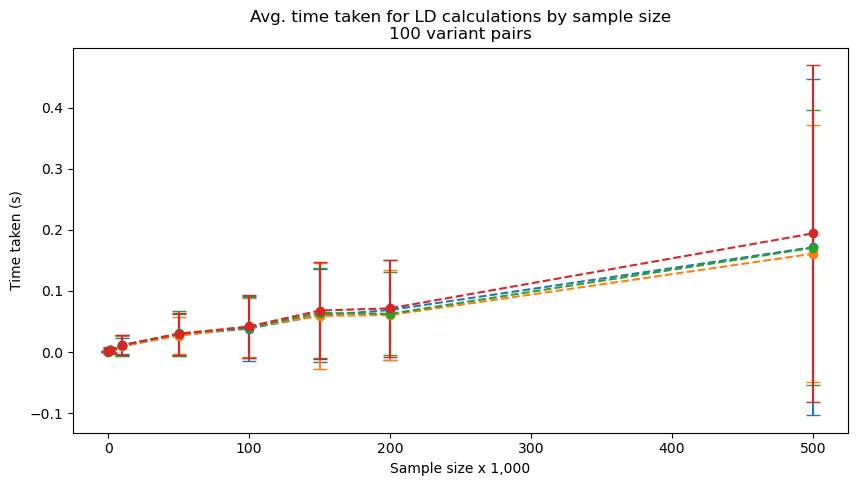

In [12]:
# plot scaling of compute time by sample size, with different max distances
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i, max_dist in enumerate(max_dists):
    ax.errorbar(
        np.array(sample_sizes) / 1_000,
        compute_times[:, i],
        yerr=compute_times_std[:, i],
        capsize=5,
        # np.array(sample_sizes)/1_000, compute_times[:,i],
        # yerr=(min_compute_times[:,i], max_compute_times[:,i]), capsize=5,
        linestyle="--",
        marker="o",
        label=f"{min_dists[i]/1_000:,} - {max_dist/1_000:,} kb",
    )

ax.set_xlabel("Sample size x 1,000")
ax.set_ylabel("Time taken (s)")
ax.set_title(
    f"Avg. time taken for LD calculations by sample size\n{num_sites:,} variant pairs"
)
plt.show()

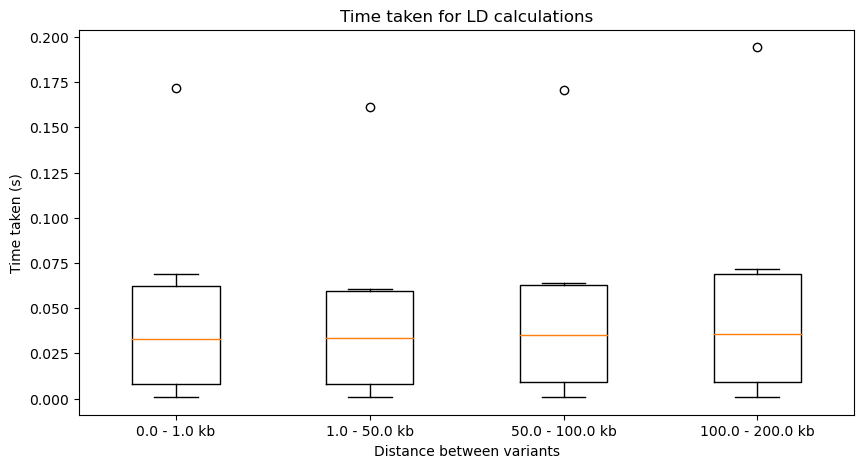

: 

In [13]:
# boxplot to show distribution of cpu times
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.boxplot(
    compute_times,
    labels=[
        f"{min_dists[i]/1_000:,} - {max_dists[i]/1_000:,} kb"
        for i in range(len(max_dists))
    ],
)
ax.set_xlabel("Distance between variants")
ax.set_ylabel("Time taken (s)")
ax.set_title(f"Time taken for LD calculations")
plt.show()